In [84]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
import warnings
warnings.filterwarnings('ignore')
import copy


def data_prep(start_date, end_date):
    df = yf.download('AMZN',start_date,end_date)
    APPL = yf.download('AAPL',start_date,end_date)
    MSFT = yf.download('MSFT',start_date,end_date)
    GOOG = yf.download('GOOG',start_date,end_date)
    VIX = yf.download("^VIX", start_date,end_date)
    usdx = yf.download('DX-Y.NYB', start_date,end_date)

    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['APPL'] = APPL['Close']
    df['MSFT'] = MSFT['Close']
    df['GOOG'] = GOOG['Close']
    df['VIX'] = VIX['Close']
    df['USDX'] = usdx['Close']

    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    macd = ema12 - ema26

    df['EMA12'] = ema12
    df['EMA26'] = ema26
    df['MACD'] = macd

    dff = pd.read_csv('dff.csv')
    dff['Date'] = pd.to_datetime(dff['DATE'])
    dff.drop(['DATE'],axis=1, inplace=True)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = pd.merge(dff, df, on='Date')

    

    print(df.info)
    df.columns = df.columns.str.replace(' ','_')
    df = df.dropna()
    dates = pd.DataFrame(df['Date'])
    df.drop(['Date'],axis=1,inplace=True)
    df.drop(['Open', 'High', 'Low', 'Adj_Close'], axis=1, inplace=True)
    y_data = df['Close']
    df_copy = copy.deepcopy(df)
    df.drop(['Close'], axis=1, inplace=True)
    X_data = df
    return X_data,y_data, dates,X_data, df_copy

start_date = '2022-04-01'
end_date = '2023-04-05'
X, y, dates,X_data,Data = data_prep(start_date, end_date)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

if X.shape[0] > 0 and y.shape[0] > 0:
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
else:
    print("Insufficient data for MinMaxScaler")

print(dates)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method DataFrame.info of       DFF       Date        Open        High         Low       Close  \
0    0.33 2022-04-01  164.149506  165.826996  162.319504  163.559998   
1    0.33 2022-04-04  164.125000  168.394501  163.205505  168.346497   
2    0.33 2022-04-05  167.741501  168.110504  163.266006  164.054993   
3    0.33 2022-04-06  161.650497  162.199997  157.254501  158.755997   
4    0.33 2022-04-07  158.399994  160.078995  154.511505  157.784500   
..    ...        ...         ...         ...         ...         ...   
248  4.83 2023-03-29   98.690002  100.419998   98.

In [85]:
Data.describe()


,DFF,Close,Volume,APPL,MSFT,GOOG,VIX,USDX,RSI,EMA12,EMA26,MACD
count,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2.931625,109.276271,7.438818e+07,148.778166,255.893958,103.940246,24.575167,105.932208,45.886030,110.555503,112.411879,-1.856376
std,1.405581,16.297614,3.100454e+07,10.428362,17.333807,10.105040,4.208939,3.296164,12.070086,16.433680,16.694676,4.176849
min,0.330000,81.820000,3.508860e+07,125.019997,214.250000,83.489998,17.870001,100.580002,18.241771,85.130379,87.810101,-13.038289
25%,1.580000,95.812500,5.494038e+07,142.085003,242.047501,95.550001,21.137499,103.507498,38.504866,96.335266,96.959078,-3.972607
50%,3.080000,107.478500,6.694420e+07,148.710007,254.114998,102.325001,23.945000,104.950001,44.820013,111.106929,113.630964,-2.010193
75%,4.330000,120.954998,8.453590e+07,155.314999,268.484993,112.870253,27.360000,108.094999,53.852374,119.171397,123.783247,0.745659
max,4.830000,148.296005,2.726620e+08,174.550003,293.470001,124.937500,34.750000,114.110001,76.659325,154.984350,158.024216,7.136492


In [86]:
print(dates)

          Date
13  2022-04-21
14  2022-04-22
15  2022-04-25
16  2022-04-26
17  2022-04-27
..         ...
248 2023-03-29
249 2023-03-30
250 2023-03-31
251 2023-04-03
252 2023-04-04

[240 rows x 1 columns]


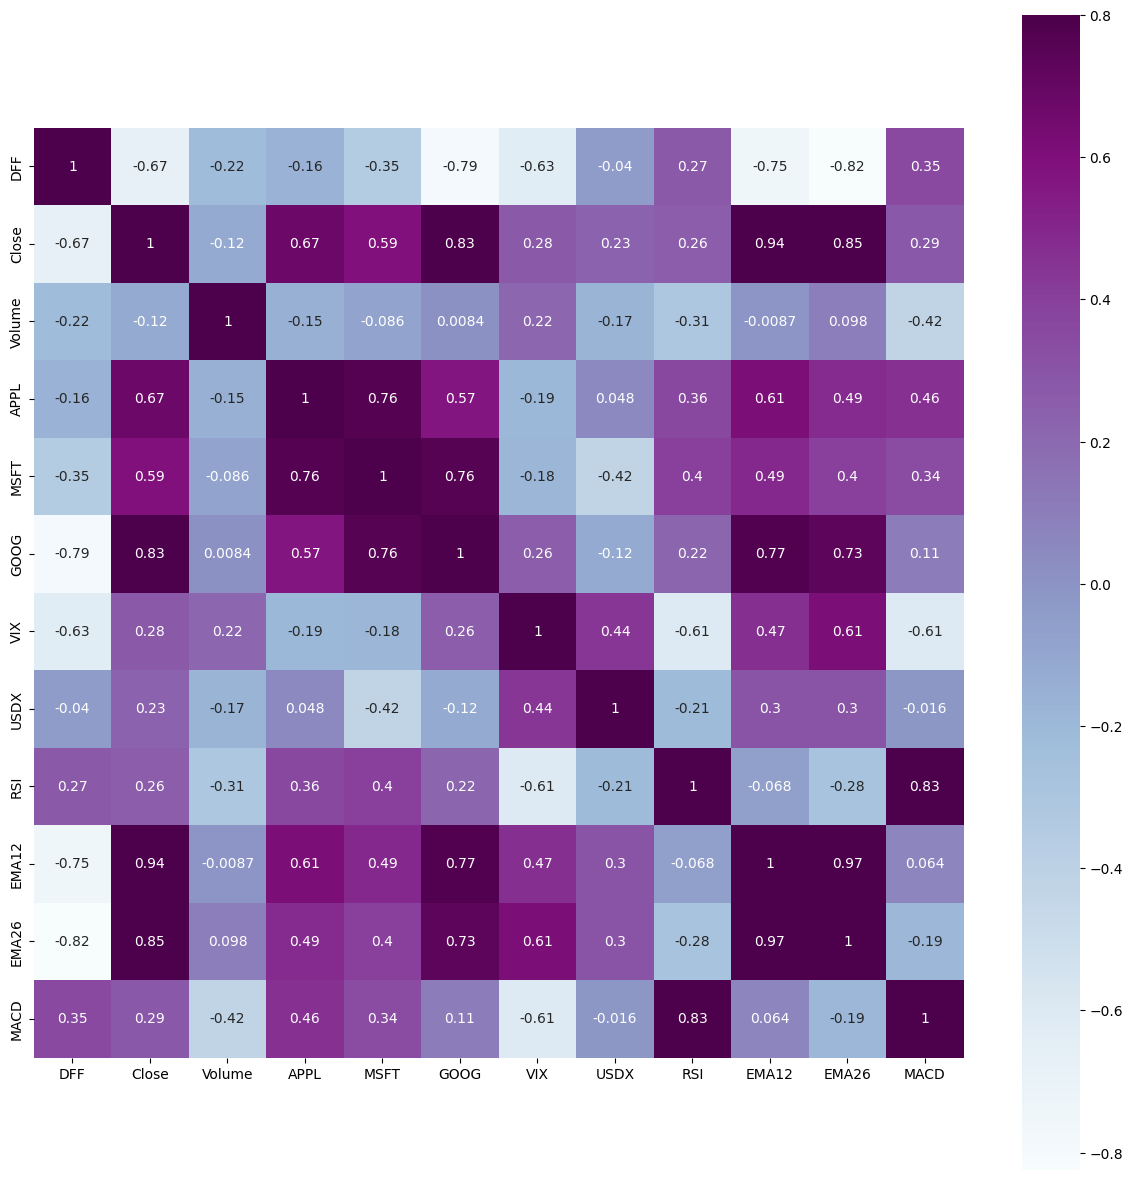

In [87]:
model_matrix_fig = Data.corr()
plt.figure(figsize=(15,15)) 
sns.heatmap(model_matrix_fig, vmax=.8, square=True, cmap="BuPu",annot=True);
plt.show()

In [88]:
train_size = int(len(X) * 0.65)
train_X, test_X = X[:train_size], X[train_size:]
train_Y, test_Y = y[:train_size], y[train_size:]

# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2
]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss=MeanSquaredError(), optimizer=Adam())

In [89]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(train_X, train_Y, epochs=100, batch_size=16, validation_data=(test_X, test_Y), callbacks=[early_stop], verbose=2, shuffle=False)

test_loss = model.evaluate(test_X, test_Y, verbose=0)
yhat = model.predict(test_X)

yhat = y_scaler.inverse_transform(yhat)
test_Y = y_scaler.inverse_transform(test_Y)

print('Test loss: ', test_loss)

mae = mean_absolute_error(test_Y, yhat)
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
r2 = r2_score(test_Y, yhat)

print('MAE: ', mae)
print('RMSE: ', rmse)
print('R²: ', r2)

Epoch 1/100
10/10 - 6s - loss: 0.2858 - val_loss: 0.0157 - 6s/epoch - 646ms/step
Epoch 2/100
10/10 - 0s - loss: 0.1612 - val_loss: 0.0125 - 129ms/epoch - 13ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0560 - val_loss: 0.1015 - 96ms/epoch - 10ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0330 - val_loss: 0.0851 - 97ms/epoch - 10ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0253 - val_loss: 0.0494 - 96ms/epoch - 10ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0239 - val_loss: 0.0530 - 103ms/epoch - 10ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0208 - val_loss: 0.0572 - 117ms/epoch - 12ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0166 - val_loss: 0.0448 - 120ms/epoch - 12ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0150 - val_loss: 0.0402 - 97ms/epoch - 10ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0111 - val_loss: 0.0358 - 92ms/epoch - 9ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0105 - val_loss: 0.0319 - 100ms/epoch - 10ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0105 - val_loss: 0.0266 - 95ms/epoch - 10ms/step
Epoch 13/1

In [90]:
train_loss = model.evaluate(train_X, train_Y, verbose=0)
pred_train = model.predict(train_X)

yhat_train = y_scaler.inverse_transform(pred_train)
train_pred_Y = y_scaler.inverse_transform(train_Y)

print('Train loss: ', train_loss)

mae_train = mean_absolute_error(train_pred_Y, yhat_train)
rmse_train = np.sqrt(mean_squared_error(train_pred_Y, yhat_train))
r2_train = r2_score(train_pred_Y, yhat_train)

print('MAE: ', mae_train)
print('RMSE: ', rmse_train)
print('R²: ', r2_train)

5/5 [==============================] - 0s 3ms/step
Train loss:  0.002727847546339035
MAE:  2.8914899581517925
RMSE:  3.471962609151847
R²:  0.9421189723489997


In [91]:
residuals = test_Y - yhat
std_residuals = np.std(residuals, ddof=1)

In [92]:
from scipy import stats

def calculate_confidence_intervals(predictions, std_residuals, confidence_levels):
    intervals = []
    for conf_level in confidence_levels:
        z_score = stats.norm.ppf(1 - (1 - conf_level) / 2)
        interval = z_score * std_residuals
        lower_bound = predictions - interval
        upper_bound = predictions + interval
        intervals.append((lower_bound, upper_bound))
    return intervals


In [93]:

from pmdarima.arima import auto_arima
def generate_future_features_arima(X_data, n_steps):
    future_features = []
    for i in range(X_data.shape[1]):
        arima_model = auto_arima(X_data.iloc[:, i], suppress_warnings=True, seasonal=False, stepwise=True)
        forecast = arima_model.predict(n_periods=n_steps)
        future_features.append(forecast)
    return np.array(future_features).T     # List is 1D. So we converted to 2D with an array. But its column first then row [[1,2,3],[4,5,6],[7,8,9]]
# But for LSTM we need it to be row wise like Excel . so we transpose it to match LSTM dims

In [94]:
import pandas_market_calendars as mcal
from pandas.tseries.offsets import BDay

def generate_trading_days(start_date, n_days):
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=start_date, end_date=start_date + BDay(n_days * 2)) # Business dayscounted. Multiplied by 2 to ensure we have enough business days
    return trading_days[:n_days]

n_future_days = 10
last_date = dates.iloc[-1].values[0]
future_dates = generate_trading_days(last_date, n_future_days)

print(future_dates)


DatetimeIndex(['2023-04-04 00:00:00+00:00', '2023-04-05 00:00:00+00:00',
               '2023-04-06 00:00:00+00:00', '2023-04-10 00:00:00+00:00',
               '2023-04-11 00:00:00+00:00', '2023-04-12 00:00:00+00:00',
               '2023-04-13 00:00:00+00:00', '2023-04-14 00:00:00+00:00',
               '2023-04-17 00:00:00+00:00', '2023-04-18 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [95]:
# # Generate future feature values
# n_future_steps = 10
# future_dates = pd.date_range(dates.iloc[-1, 0], periods=n_future_steps + 1, closed='right')

# Get column names from the original DataFrame
column_names = X_data.columns


# Generate future feature values using ARIMA
future_features = generate_future_features_arima(X_data, n_future_days)

# Scale the future feature values
scaled_future_features = scaler.transform(future_features)


# Reshape the future feature values to a 3D array
scaled_future_features = scaled_future_features.reshape((scaled_future_features.shape[0], 1, scaled_future_features.shape[1]))

# Predict future closing prices
future_closing_prices = model.predict(scaled_future_features)

# Inverse transform the predicted closing prices
future_closing_prices = y_scaler.inverse_transform(future_closing_prices)

# Display the future closing prices
future_closing_prices_df = pd.DataFrame(future_closing_prices, index=future_dates, columns=['Predicted_Close'])
print(future_closing_prices_df)


1/1 [==============================] - 0s 27ms/step
                           Predicted_Close
2023-04-04 00:00:00+00:00       105.133064
2023-04-05 00:00:00+00:00       105.372688
2023-04-06 00:00:00+00:00       105.609184
2023-04-10 00:00:00+00:00       105.836121
2023-04-11 00:00:00+00:00       106.051811
2023-04-12 00:00:00+00:00       106.256439
2023-04-13 00:00:00+00:00       106.450890
2023-04-14 00:00:00+00:00       106.636276
2023-04-17 00:00:00+00:00       106.813683
2023-04-18 00:00:00+00:00       106.984131


In [96]:
confidence_levels = [0.90, 0.95, 0.99]
future_intervals = calculate_confidence_intervals(future_closing_prices, std_residuals, confidence_levels)


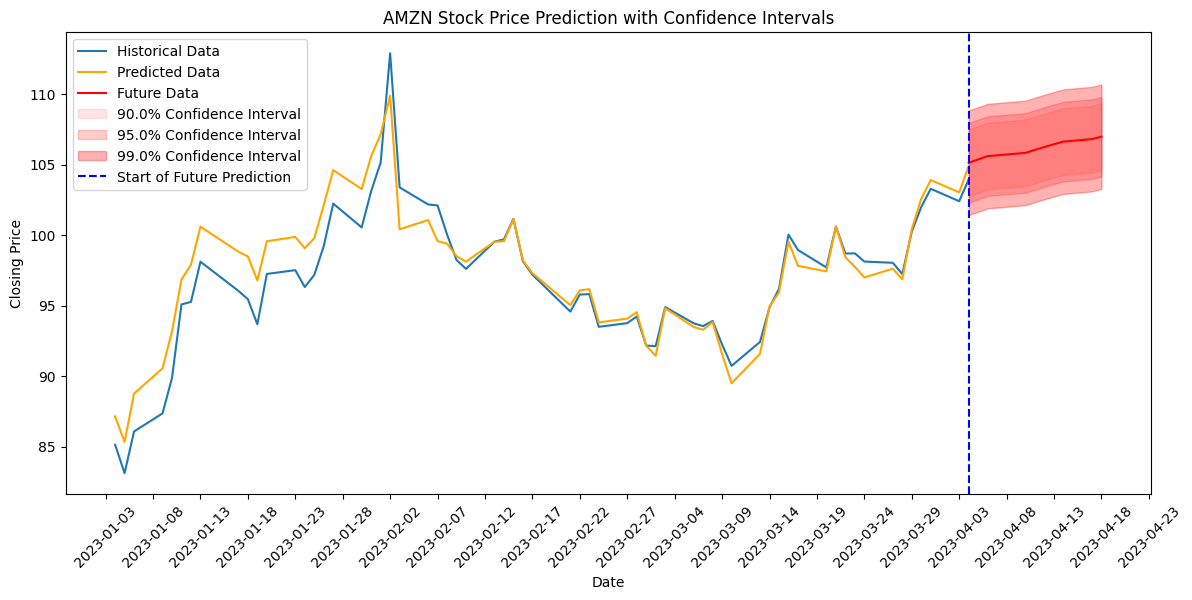

In [98]:
import matplotlib.dates as mdates


n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)
mask = dates['Date'] >= start_date 
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1)]

predicted_mask = dates.iloc[-yhat.shape[0]:]['Date'] >= start_date
filtered_yhat = yhat[predicted_mask.to_numpy().reshape(-1)]
filtered_predicted_dates = dates.iloc[-yhat.shape[0]:][predicted_mask]

plt.figure(figsize=(14, 6))
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data')
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')

for i, conf_level in enumerate(confidence_levels):
    lower_bound, upper_bound = future_intervals[i]
    plt.fill_between(future_dates, lower_bound.ravel(), upper_bound.ravel(), color='red', alpha=0.1 * (i + 1),
                     label=f'{conf_level * 100}% Confidence Interval')

# Draw a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction')

# Display day-by-day dates on the x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Stock Price Prediction with Confidence Intervals')
plt.legend()
plt.show()


3/3 [==============================] - 0s 3ms/step


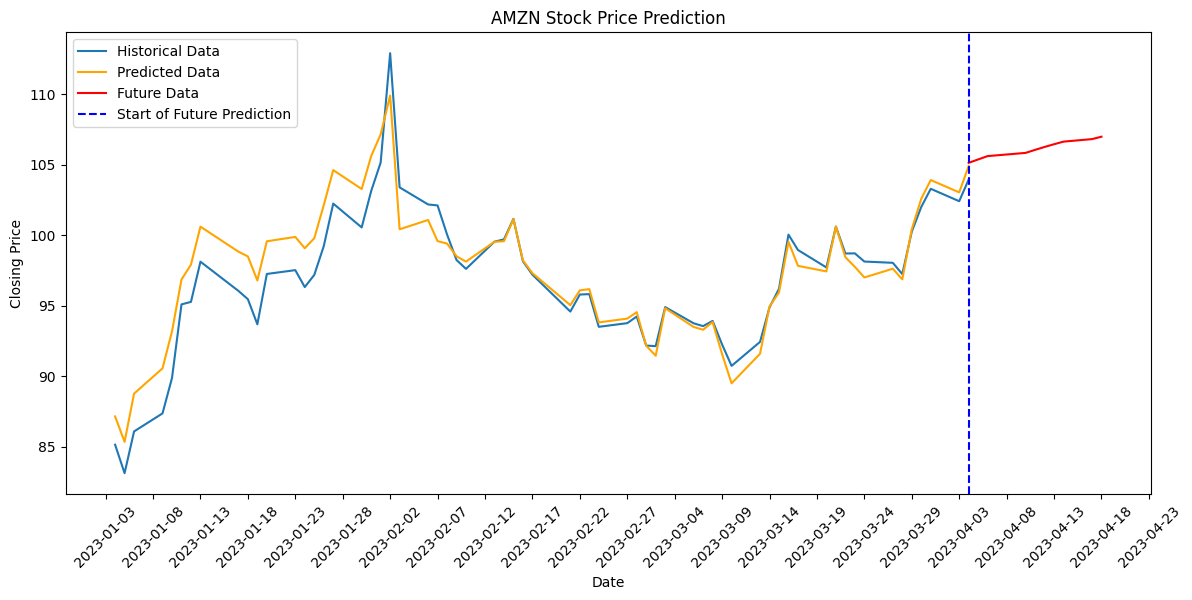

In [101]:
import matplotlib.dates as mdates

# Predict on the test set
test_Y_pred = model.predict(test_X)

# Filter the data for the last 3 months
n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)
mask = dates['Date'] >= start_date 
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1)]  # reshaping to have a 1-1 mapping

# Filter the predicted data and extracted the DATES
predicted_mask = dates.iloc[-yhat.shape[0]:]['Date'] >= start_date
filtered_yhat = yhat[predicted_mask.to_numpy().reshape(-1)]
filtered_predicted_dates = dates.iloc[-yhat.shape[0]:][predicted_mask]

plt.figure(figsize=(14, 6))
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data')
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')

# Draw a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction')

# Display day-by-day dates on the x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()


In [35]:
# import pickle

# # Save the model to a file
# with open('lstm_model_final.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # Save the MinMaxScaler objects for X and y
# with open('x_scaler_final.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# with open('y_scaler_final.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)


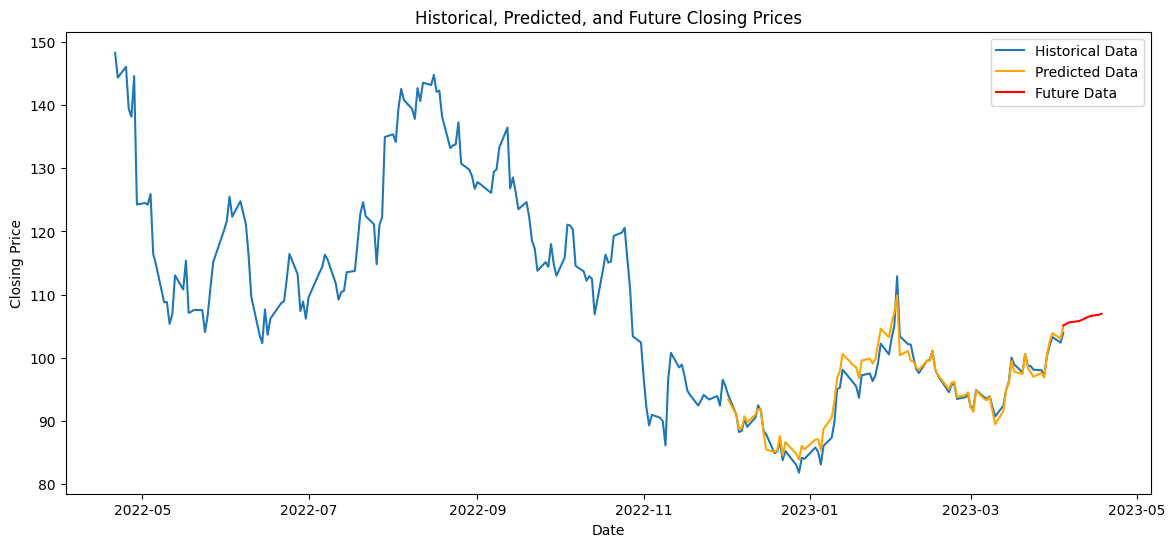

In [102]:


plt.figure(figsize=(14, 6))
plt.plot(dates, y_scaler.inverse_transform(y), label='Historical Data')
plt.plot(dates.iloc[-test_Y.shape[0]:], yhat, label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical, Predicted, and Future Closing Prices')
plt.legend()
plt.show()


In [37]:
print(yhat.shape)

(49, 1)


In [38]:
# Confidence intervals
# Central tendencies
# 

In [39]:
# tried via linear regression - > The residuals were not normally distributed. Lot of other factors impact LR. 
# Univariate LSTM - > Lot of other factors impact LR. 
# Correlation
# Scaling - Why was it imp to have scaling
    # How did you achieve scaling 
    # How is it benefiting right now
# WHy OHL was removed
# Model
# WHy trading days